In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

In [17]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu'))
# model.add(keras.layers.Dropout(rate=0.5))  # rate是丢弃的比例
# AlphaDropout相对于普通Dropout优势: 均值和方差不变 归一化性质也不变
model.add(keras.layers.AlphaDropout(rate=0.2))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(0.001),
              metrics=['accuracy'])

In [20]:
# 查看丢弃rate后的数据
tf.random.set_seed(0)
# layer = tf.keras.layers.Dropout(0.5, input_shape=(2,))
layer=tf.keras.layers.AlphaDropout(0.5,input_shape=(2,))
data = np.arange(1, 13).reshape(6, 2).astype(np.float32)
print(data)
outputs = layer(data, training=True)
print('-' * 50)
print(outputs)

[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]
 [11. 12.]]
--------------------------------------------------
tf.Tensor(
[[-0.7791938 -0.7791938]
 [ 3.4384084  4.3248134]
 [-0.7791938  6.097623 ]
 [-0.7791938  7.870433 ]
 [ 8.756838  -0.7791938]
 [10.529648  11.416052 ]], shape=(6, 2), dtype=float32)


In [21]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 100)               10100     
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 100)              

In [22]:
print(len(model.layers))

23


In [23]:
print(model.variables)

[<tf.Variable 'dense_21/kernel:0' shape=(784, 100) dtype=float32, numpy=
array([[ 0.0091306 , -0.0459227 ,  0.06012887, ...,  0.03503489,
        -0.0504012 , -0.07751266],
       [ 0.02590074,  0.01700352,  0.04791552, ...,  0.0720017 ,
         0.07990901,  0.05613111],
       [ 0.05436131,  0.01309448,  0.06928839, ...,  0.00451397,
        -0.01824505,  0.04402028],
       ...,
       [-0.03801782,  0.04643896,  0.00742005, ..., -0.06630611,
         0.01328414,  0.07816349],
       [ 0.01204269,  0.00275543, -0.01860609, ..., -0.0020112 ,
        -0.06239635, -0.03644305],
       [-0.06852627, -0.0336123 , -0.02531214, ..., -0.0300247 ,
        -0.06364018, -0.07683984]], dtype=float32)>, <tf.Variable 'dense_21/bias:0' shape=(100,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [24]:
logdir = './dnn_selu_dropout_callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir, ),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks, workers=-1)

Epoch 1/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8534 - accuracy: 0.7101 - val_loss: 0.5487 - val_accuracy: 0.8248
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5668 - accuracy: 0.8060 - val_loss: 0.5332 - val_accuracy: 0.8310
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4978 - accuracy: 0.8268 - val_loss: 0.4869 - val_accuracy: 0.8482
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4556 - accuracy: 0.8403 - val_loss: 0.4803 - val_accuracy: 0.8546
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4274 - accuracy: 0.8502 - val_loss: 0.4554 - val_accuracy: 0.8614
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4020 - accuracy: 0.8588 - val_loss: 0.4351 - val_accuracy: 0.8654
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3855 - accuracy: 0.8641 - val_loss: 0.4326 - val_ac

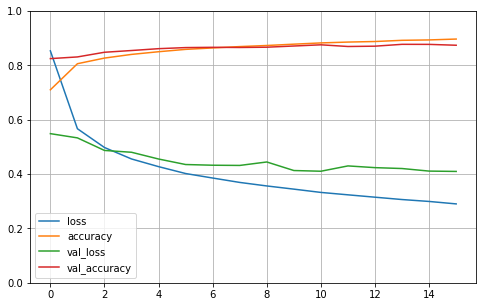

In [25]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


plot_learning_curves(history)

In [26]:
print(model.evaluate(x_test_scaled, y_test, verbose=0))

[0.45693179965019226, 0.8567000031471252]
